### Graph Demonstration

In [2]:
# we import the DGL python package construct the GNN for the communication dataset

import dgl

# we define the function buil_communication
def build_communication():
    # define function g to make the graph in DGL
    g = dgl.DGLGraph()
    # we add 38 nodes into the graph; nodes are labeled from 0~37
    g.add_nodes(38)
    # we make a list of tuples of all the edges
    edge_list = [(1, 9), (2, 23), (2, 24), (2, 26), (3, 14), (3, 15),
        (3,25), (5, 1), (5, 4), (5, 10), (5, 20), (5, 31), (5, 37),
        (6, 16), (6, 33), (7,35), (8, 8), (8, 25), (8, 30),(9,1), (10, 4), (10, 5),(10,17),(10,18),
        (10, 20), (10,27), (10,37), (12, 19), (12, 27),
        (14, 3), (14, 15), (14, 25), (14, 29), (15, 3), (15, 14), (15, 15),(15,25),
        (16, 6), (17, 10), (17, 12), (17, 15), (17, 18),(17, 19), (17, 27), (17, 37), (19, 12), (19, 17), 
        (19, 27), (20, 4), (21, 21), (21,22), (21,32), (21,35),
        (22,8),(22,32),(23,8),(23,26), (24,2),(25,3),(25,14),(25,15),(25,29),(25,30),(26,23),
        (27, 12), (27,17), (27,19), (29, 14), (29, 25), (29, 30), (30, 15), (30,25),(30,29),(30,36),
        (32, 21), (32, 22), (32, 35), (36, 12), (36, 29),(36,30), (36,37),
        (34,2),(34,27),(34,34),(35,7),(37,4),(37,5),(37,10),(37,12),(37,15),(37,17),(37,25),(37,29),(37,30),(37,36)]
    # add edges two lists of nodes: src and dst
    #zip maps the src list with the dst list
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional; students and teachers and TAs both interact with each other
    g.add_edges(dst, src)

    return g

In [3]:
# run the build communication function to find the number of nodes and edges
G = build_communication()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 38 nodes.
We have 190 edges.


In [4]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
# the networkx library does a GREAT job at visualizing complex data
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.1, .9, .8]])

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


In [6]:
import torch
# lets make a 2D tensor with ones on the diagonal and zeros elsewhere with 38 rows
G.ndata['feat'] = torch.eye(38)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)
    
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(38, 5, 2)

In [8]:
inputs = torch.eye(38)
labeled_nodes = torch.tensor([1, 13])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7392
Epoch 1 | Loss: 0.6930
Epoch 2 | Loss: 0.6495
Epoch 3 | Loss: 0.6126
Epoch 4 | Loss: 0.5756
Epoch 5 | Loss: 0.5397
Epoch 6 | Loss: 0.5047
Epoch 7 | Loss: 0.4712
Epoch 8 | Loss: 0.4397
Epoch 9 | Loss: 0.4110
Epoch 10 | Loss: 0.3849
Epoch 11 | Loss: 0.3621
Epoch 12 | Loss: 0.3427
Epoch 13 | Loss: 0.3265
Epoch 14 | Loss: 0.3130
Epoch 15 | Loss: 0.3016
Epoch 16 | Loss: 0.2920
Epoch 17 | Loss: 0.2838
Epoch 18 | Loss: 0.2766
Epoch 19 | Loss: 0.2702
Epoch 20 | Loss: 0.2643
Epoch 21 | Loss: 0.2589
Epoch 22 | Loss: 0.2537
Epoch 23 | Loss: 0.2488
Epoch 24 | Loss: 0.2441
Epoch 25 | Loss: 0.2395
Epoch 26 | Loss: 0.2351
Epoch 27 | Loss: 0.2308
Epoch 28 | Loss: 0.2266
Epoch 29 | Loss: 0.2225
Epoch 30 | Loss: 0.2184
Epoch 31 | Loss: 0.2145
Epoch 32 | Loss: 0.2107
Epoch 33 | Loss: 0.2069
Epoch 34 | Loss: 0.2032
Epoch 35 | Loss: 0.1996
Epoch 36 | Loss: 0.1961
Epoch 37 | Loss: 0.1926
Epoch 38 | Loss: 0.1893
Epoch 39 | Loss: 0.1860
Epoch 40 | Loss: 0.1828
Epoch 41 | Loss: 0.1796
Ep

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


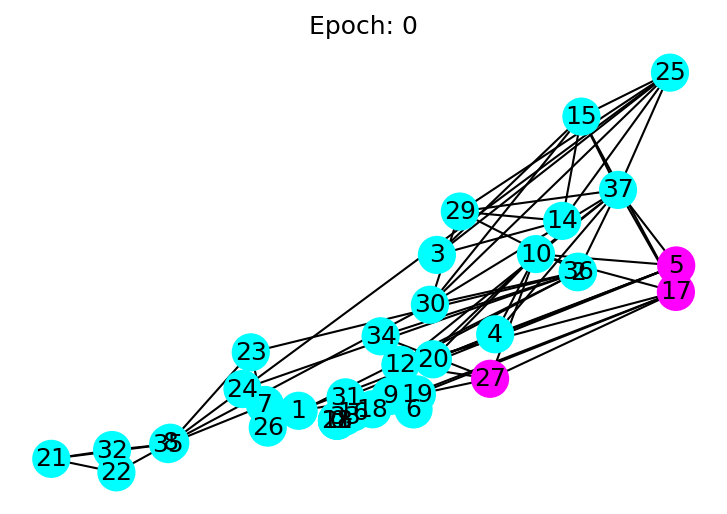

In [10]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(38):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
# draw the prediction of the first epoch
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
ani.save('yeet.mp4')